# Train on separate images (CNN-Only) on InceptionV3 output

In [1]:
import numpy as np
import os
from os.path import join
from keras import layers, callbacks, metrics
from keras.models import Model
from utils import preprocess_images_tf, take
from tqdm import tqdm
from image_generators import count_num_videos
from inception_generators import load_whole_dataset

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras_utils import set_keras_session
set_keras_session(0.45)

In [3]:
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [4]:
frame_number = 50
width = 320
height = 240

dataset_dir = join('datasets', dataset, ('separate_frames_{}_h_{}_w_{}_inception').format(frame_number, height, width))

(X_train, Y_train), (X_valid, Y_valid) = list(load_whole_dataset(dataset_dir, 'cnn', ['train', 'valid']))
(X_train_rnn, Y_train_rnn), (X_valid_rnn, Y_valid_rnn) = list(load_whole_dataset(dataset_dir, 'rnn', ['train', 'valid']))

In [5]:
from np_utils import shuffle

X_train_rnn, Y_train_rnn = shuffle([X_train_rnn, Y_train_rnn])
X_train_samples = len(X_train_rnn)

X_train_rnn_1, Y_train_rnn_1 = X_train_rnn[:X_train_samples // 2], Y_train_rnn[:X_train_samples // 2]
X_train_rnn_2, Y_train_rnn_2 = X_train_rnn[X_train_samples // 2:], Y_train_rnn[X_train_samples // 2:]

In [43]:
X_train_1 = np.concatenate([X_train_video for X_train_video in X_train_rnn_1])
Y_train_1 = np.concatenate([np.tile(Y_train_video, [frame_number, 1]) for Y_train_video in Y_train_rnn_1])

In [9]:
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

In [10]:
from keras.models import Model

input_layer = layers.Input((X_train_1.shape[1],))
x = input_layer
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
model = Model(input_layer, outputs=predictions)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 1,054,731
Trainable params: 1,054,731
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

model_filepath = join('models', dataset, 'inception_dense512_dropout05_trained_10_epochs_no_fine_tuning_2.h5')
checkpointer = callbacks.ModelCheckpoint(filepath=model_filepath, monitor='val_acc', verbose=1, save_best_only=True)
early_stopper = callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [47]:
history = model.fit(X_train_1, Y_train_1, validation_data=(X_valid, Y_valid), 
          batch_size=128, epochs=30, 
          callbacks=[checkpointer, early_stopper])

Train on 28150 samples, validate on 23450 samples
Epoch 1/30
28150/28150 [==============================] - 2s 75us/step - loss: 0.3880 - acc: 0.8848 - top_3: 0.9631 - val_loss: 0.5705 - val_acc: 0.8156 - val_top_3: 0.9528

Epoch 00001: val_acc improved from -inf to 0.81561, saving model to models/UCF11/inception_dense512_dropout05_trained_10_epochs_no_fine_tuning_2.h5
Epoch 2/30
28150/28150 [==============================] - 2s 65us/step - loss: 0.0983 - acc: 0.9729 - top_3: 0.9980 - val_loss: 0.5641 - val_acc: 0.8248 - val_top_3: 0.9644

Epoch 00002: val_acc improved from 0.81561 to 0.82482, saving model to models/UCF11/inception_dense512_dropout05_trained_10_epochs_no_fine_tuning_2.h5
Epoch 3/30
28150/28150 [==============================] - 2s 65us/step - loss: 0.0612 - acc: 0.9852 - top_3: 0.9989 - val_loss: 0.5347 - val_acc: 0.8349 - val_top_3: 0.9672

Epoch 00003: val_acc improved from 0.82482 to 0.83493, saving model to models/UCF11/inception_dense512_dropout05_trained_10_epoch

Here we collect metrics about the accuracy on the video, since the model only works with single images:
* Approach 1: Compute the mean of all predictions on all frames of a video, then take the best prediction.
* Approach 2: Take the predicted best for each frame (argmax), and count how many times that class is predicted as the best one into the video frames. Then take the class with the highest count.
* Approach 3 (not implemented but tested): instead of the mean, compute the product (since we work with probabilities). Yields a lower result than using the mean.

Here we load the best model:

In [48]:
from keras.models import load_model

model = load_model(model_filepath, custom_objects={'top_3': top_3_k_categorical_accuracy})

In [49]:
from np_utils import batch

def collect_statistics_on_videos():

    from collections import Counter

    count_videos = 0
    count_top_1 = 0
    count_top_3 = 0
    count_top_1_argmax = 0

    for frames, labels in tqdm(batch([X_valid, Y_valid], batch_size=frame_number), 
                               total=len(X_valid) // frame_number,
                              desc='Collecting aggregate statistics on videos'):

        ### Compute the predicted labels using the model

        true_labels = labels[0]
        true_label_idx = np.argmax(true_labels)
        predicted_labels = model.predict(frames)

        ### Update counters with Approach 1 (mean)

        predicted_labels_mean = np.mean(predicted_labels, axis=0)
        predicted_labels_mean_idx = np.argmax(predicted_labels_mean)
        idx_sorted_top_3 = np.argsort(predicted_labels_mean)[-3:]

        if true_label_idx in idx_sorted_top_3:
            count_top_3 += 1

        if true_label_idx == predicted_labels_mean_idx:
            count_top_1 += 1

        ### Update count with Approach 2 (highest count)

        predicted_labels_argmax = np.argmax(predicted_labels, axis=1)
        counter = Counter(predicted_labels_argmax)

        if counter.most_common(1)[0][0] == true_label_idx:
            count_top_1_argmax += 1

        ### Update number of videos

        count_videos += 1
        
        
    print('Top 1 accuracy (using mean):', count_top_1 / count_videos)
    print('Top 3 accuracy (using mean):', count_top_3 / count_videos)
    print('Top 1 accuracy (using highest count):', count_top_1_argmax / count_videos)

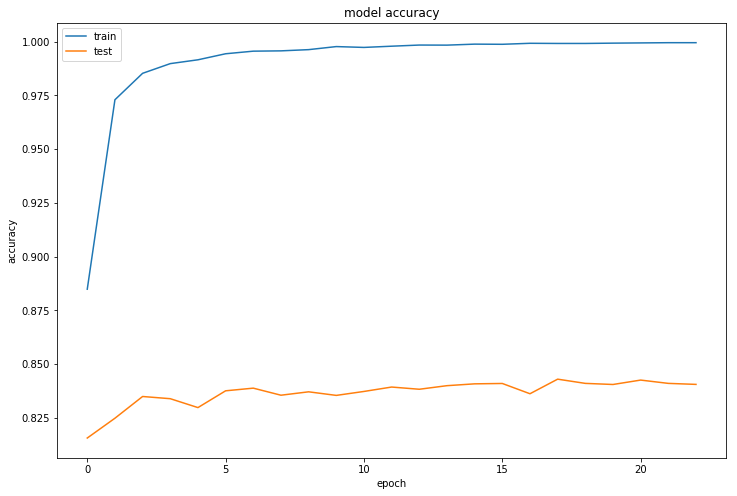

In [50]:
%matplotlib inline
from plot_utils import plot_history

plot_history(history)

In [51]:
collect_statistics_on_videos()

Top 1 accuracy (using mean): 0.9019189765458422
Top 3 accuracy (using mean): 0.9914712153518124
Top 1 accuracy (using highest count): 0.8976545842217484


In [72]:
X_train_2_predictions = np.array([model.predict(X_train_2_video) for X_train_2_video in X_train_rnn_2])
X_valid_predictions = np.array([model.predict(X_valid_video) for X_valid_video in X_valid_rnn])

In [91]:
input_layer = layers.Input((X_train_2_predictions.shape[1:]))
x = input_layer
# x = layers.Flatten()(x)
# x = layers.Dense(128)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
rnn = Model(input_layer, outputs=predictions)
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 50, 11)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               71680     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 11)                1419      
Total params: 73,099
Trainable params: 73,099
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
from keras.optimizers import SGD

sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)

rnn.compile(optimizer=sgd, loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

In [95]:
rnn.fit(X_train_2_predictions, Y_train_rnn_2, validation_data=(X_valid_predictions, Y_valid_rnn), epochs=100)

Train on 563 samples, validate on 469 samples
Epoch 1/100
563/563 [==============================] - 3s 6ms/step - loss: 1.7623 - acc: 0.8650 - top_3: 0.9663 - val_loss: 1.8218 - val_acc: 0.8316 - val_top_3: 0.8998
Epoch 2/100
563/563 [==============================] - 2s 4ms/step - loss: 1.7294 - acc: 0.8650 - top_3: 0.9680 - val_loss: 1.7778 - val_acc: 0.8380 - val_top_3: 0.9041
Epoch 3/100
563/563 [==============================] - 2s 4ms/step - loss: 1.6786 - acc: 0.8863 - top_3: 0.9663 - val_loss: 1.7234 - val_acc: 0.8401 - val_top_3: 0.9041
Epoch 4/100
563/563 [==============================] - 3s 5ms/step - loss: 1.6044 - acc: 0.8934 - top_3: 0.9663 - val_loss: 1.6569 - val_acc: 0.8422 - val_top_3: 0.9062
Epoch 5/100
563/563 [==============================] - 3s 5ms/step - loss: 1.5186 - acc: 0.9005 - top_3: 0.9663 - val_loss: 1.5647 - val_acc: 0.8443 - val_top_3: 0.9062
Epoch 6/100
563/563 [==============================] - 3s 5ms/step - loss: 1.4086 - acc: 0.8686 - top_3: 0.96

563/563 [==============================] - 2s 3ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 47/100
563/563 [==============================] - 2s 4ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 48/100
563/563 [==============================] - 3s 4ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 49/100
563/563 [==============================] - 3s 5ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 50/100
563/563 [==============================] - 3s 5ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 51/100
563/563 [==============================] - 3s 5ms/step - loss: 1.1921e

563/563 [==============================] - 3s 5ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 91/100
563/563 [==============================] - 3s 4ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 92/100
563/563 [==============================] - 3s 5ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 93/100
563/563 [==============================] - 3s 5ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 94/100
563/563 [==============================] - 2s 4ms/step - loss: 1.1921e-07 - acc: 0.0906 - top_3: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 0.1023 - val_top_3: 0.0000e+00
Epoch 95/100
563/563 [==============================] - 2s 3ms/step - loss: 1.1921e